In [41]:
%matplotlib inline
import warnings

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from pymc3 import Model, Normal, Bernoulli, Beta, Slice, sample
from pymc3.distributions import Interpolated
from scipy import stats

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [42]:
def gen_data(n):
    X1 = np.random.randint(1, 7, n)
    X2 = np.random.randint(1, 7, n)
    # valid = (X1 + X2) != 7
    # X1 = X1[valid]
    # X2 = X2[valid]
    X3 = X1 * X2
    Y = []

    for i, (x1, x2) in enumerate(zip(X1, X2)):
        y = 0
        if ((x1 < 4) and (x2 < 4)) or ((x1 >= 4) and (x2 >= 4)): # 2d2 rule
        # if x2 < 4: # 2d1 rule
        # if (x1 + x2) > 7:
            y = 1
        Y.append(y)
    Y = np.array(Y)
    return X1, X2, X3, Y

In [45]:
np.random.seed(1)
X1, X2, X3, Y = gen_data(1)

basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    b0 = Beta("b0", alpha=1, beta=1)
    b1 = Beta("b1", alpha=1, beta=1)
    b2 = Beta("b2", alpha=1, beta=1)
    b3 = Beta("b3", alpha=1, beta=1)

    # Expected value of outcome
    logit = b0 + b1*X1 + b2*X2 + b3*X3
    p_hat = 1 / (1 + np.exp(-logit))

    # Likelihood (sampling distribution) of observations
    Y_obs = Bernoulli("Y_obs", p=p_hat, observed=Y)

    # draw 1000 posterior samples
    trace = sample(1000)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b3, b2, b1, b0]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [46]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [50]:
X1, X2, X3, Y = gen_data(1)

basic_model = Model()
with basic_model:
    # Priors for unknown model parameters
    b0 = Beta("b0", alpha=1, beta=1)
    b1 = Beta("b1", alpha=1, beta=1)
    b2 = Beta("b2", alpha=1, beta=1)
    b3 = Beta("b3", alpha=1, beta=1)

    # Expected value of outcome
    logit = b0 + b1*X1 + b2*X2 + b3*X1*X2 
    # Maybe implement actual rules here with uniform prior over boundaries
    p_hat = 1 / (1 + np.exp(-logit))

    # Likelihood (sampling distribution) of observations
    Y_obs = Bernoulli("Y_obs", p=p_hat, observed=Y)

    # draw 1000 posterior samples
    trace = sample(5000)

traces = [trace]

for _ in range(1):
    np.random.seed(_+23)
    # generate more data
    X1, X2, X3, Y = gen_data(20)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        b0 = from_posterior('b0', trace['b0'])
        b1 = from_posterior('b1', trace['b1'])
        b2 = from_posterior('b2', trace['b2'])
        b3 = from_posterior('b3', trace['b3'])
        
        # Expected value of outcome
        logit = b0 + b1*X1 + b2*X2 + b3*X1*X2
        p_hat = 1 / (1 + np.exp(-logit))

        # Likelihood (sampling distribution) of observations
        Y_obs = Bernoulli("Y_obs", p=p_hat, observed=Y)

        # draw 1000 posterior samples
        trace = sample(5000)
        traces.append(trace)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b3, b2, b1, b0]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 2 iterations.


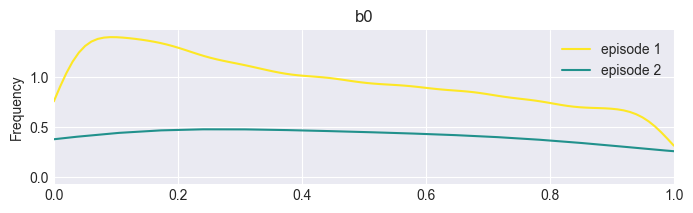

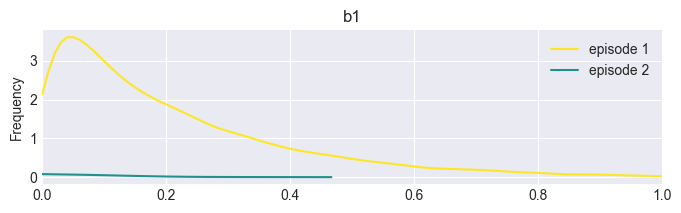

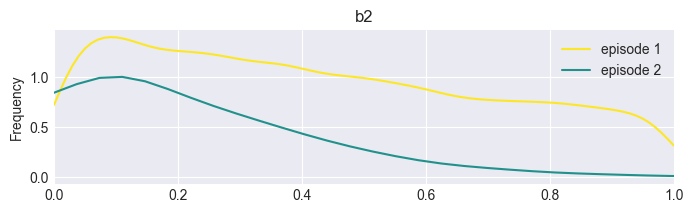

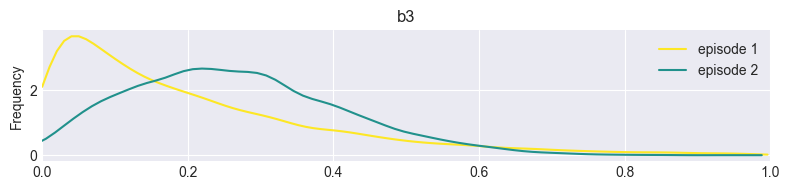

In [51]:
print("Posterior distributions after " + str(len(traces)) + " iterations.")
cmap = mpl.cm.viridis
for param in ["b0", "b1", "b2", "b3"]:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)), label=f'episode {update_i+1}' if update_i==0 or update_i==len(traces)-1 else None)
    plt.legend()
    plt.ylabel("Frequency")
    plt.title(param)
    plt.xlim(0, 1)
plt.tight_layout();

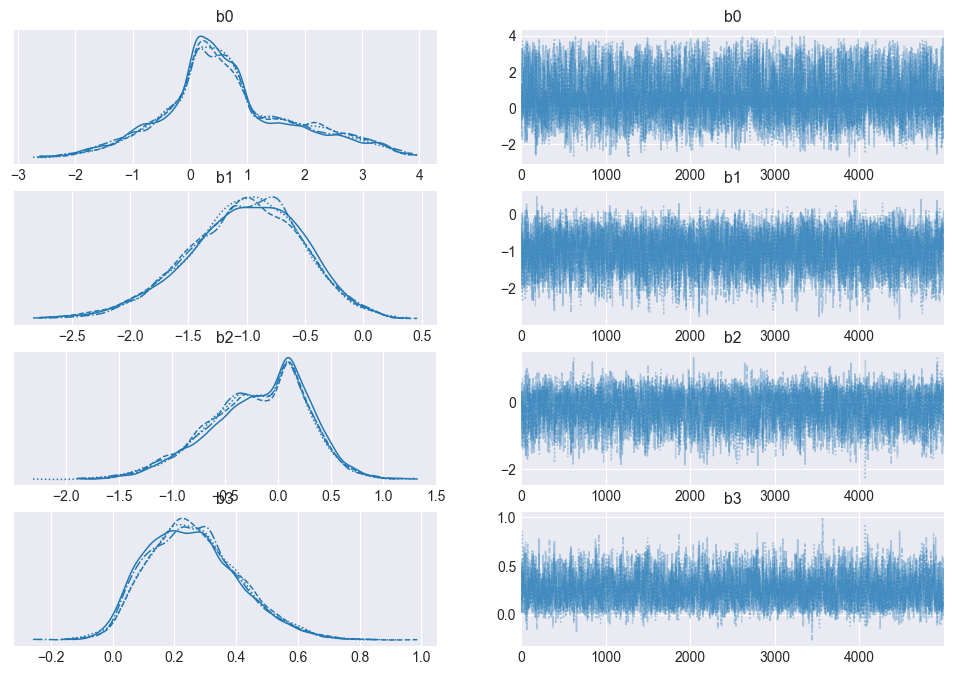

In [52]:
with model:
    az.plot_trace(traces[-1], var_names=["b0", "b1", 'b2', 'b3']);